In [1]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from PIL import Image

from models.cnn import ResNet

/home/phuc/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ep = 4
if (ep+1 == 1 or (ep+1) % 5 == 0):
    print("True")

True


In [3]:
# Check loss per batch of previous trained models
base_dir = "/mnt/beegfs/scratch/phuc/trained_resnets"
run_id = "run-10"
run_dir = os.path.join(base_dir, run_id)

with open(os.path.join(run_dir, "loss.pkl"), "rb") as f:
    logs = pickle.load(f)

train_loss = logs["train_loss"]
val_loss = logs["val_loss"]

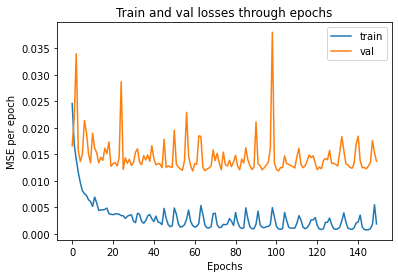

In [7]:
# Train loss and val loss
plt.figure(facecolor="white")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE per epoch")
plt.title("Train and val losses through epochs")
plt.savefig("train-val-err.png")
plt.show()

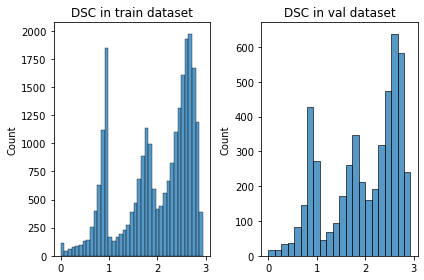

In [2]:
# Visualize the distribution of the training scores
model_id = "model_4"
dice_score_dir = f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/dices_train.pkl"
val_score_dir = f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/dices_val.pkl"
with open(dice_score_dir, "rb") as f:
    dices_tr = pickle.load(f)
with open(val_score_dir, "rb") as f:
    dices_vl = pickle.load(f)

fig, axe = plt.subplots(nrows=1, ncols=2)
sns.histplot(ax=axe[0], data=list(dices_tr.values()))
axe[0].set_title("DSC in train dataset")
sns.histplot(ax=axe[1], data=list(dices_vl.values()))
axe[1].set_title("DSC in val dataset")
plt.tight_layout()
plt.show()

In [5]:
# Load a seg map and check for the whole volume of the tumor
model_id = "model_4"
true_seg = f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/True-segs"
# pred_seg = f"/mnt/beegfs/scratch/phuc/seg-quality-control/{model_id}/dices_val.pkl"

seg_name = "Epoch40_Seg7833.pt"
a = torch.load(os.path.join(true_seg, seg_name))
torch.count_nonzero(a) / torch.numel(a)

tensor(0.0203)

In [10]:
dice_dict = "/mnt/beegfs/scratch/phuc/seg-quality-control/multiple-unet-exp/experiment-2/unet-results/exp_5/train_dice_list.pkl"
with open(dice_dict, "rb") as f:
    a = pickle.load(f)

In [11]:
dices = {
    0: [], 1: [], 2: [], 3: []
}
for dic in a.values():
    for d in dices.keys():
        #print(dic)
        dices[d].append(dic[d])

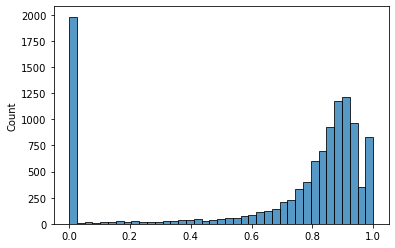

In [14]:
plt.figure()
sns.histplot(data=dices[3])
plt.show()

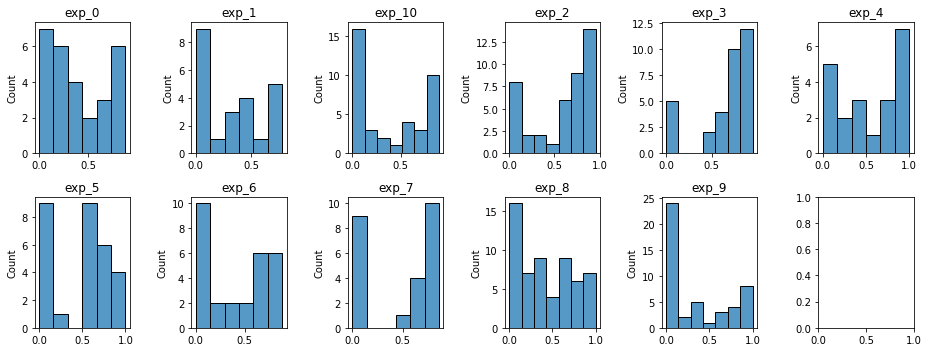

In [56]:
model_list = sorted(os.listdir("/mnt/beegfs/scratch/phuc/seg-quality-control/multiple-unet-exp/experiment-2/unet-results"))
tumor_label = 1
tumor_label_thresholded = 2
threshold = [0.5, 0.6]
folder = "test"
dice_dict_of_class = {
    m: [] for m in model_list
}

for model in model_list:
    
    dice_dict = "/mnt/beegfs/scratch/phuc/seg-quality-control/multiple-unet-exp/experiment-2/unet-results/" + model + "/" + folder + "_dice_list.pkl" 
    with open(dice_dict, "rb") as f:
        a = pickle.load(f)
        for k, v in a.items():
            if v[tumor_label_thresholded] >= 0.2 and v[tumor_label_thresholded] <= 0.3:
                dice_dict_of_class[model].append(v[tumor_label])

fig, axe = plt.subplots(nrows=2, ncols=(len(model_list)//2)+1, figsize=(13, 5))
axe = axe.ravel()

for i, model in enumerate(model_list):
    sns.histplot(data=dice_dict_of_class[model], ax=axe[i])
    axe[i].set_title(model)

plt.tight_layout()
plt.show()

In [40]:
low_dices_3 = [k for k, v in a.items() if v[3] < 0.001]
print(low_dices_3[:3])

['0.png', '100.png', '1016.png']


In [47]:
# Check to see if different models have different Dices for a specific file
file_name, folder = "937.png", "test"
model_list = os.listdir("/mnt/beegfs/scratch/phuc/seg-quality-control/multiple-unet-exp/experiment-2/unet-results")
dice_dict_per_file = {
    0: [], 1: [], 2: [], 3: []
}

for model in model_list:
    
    dice_dict = "/mnt/beegfs/scratch/phuc/seg-quality-control/multiple-unet-exp/experiment-2/unet-results/" + model + "/" + folder + "_dice_list.pkl" 
    with open(dice_dict, "rb") as f:
        a = pickle.load(f)
        for k, v in a[file_name].items():
            dice_dict_per_file[k].append(v)


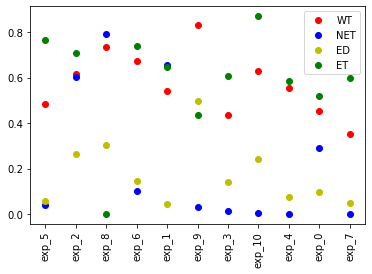

In [49]:
plt.figure()
plt.plot(model_list, dice_dict_per_file[0], "ro", label="WT")
plt.plot(model_list, dice_dict_per_file[1], "bo", label="NET")
plt.plot(model_list, dice_dict_per_file[2], "yo", label="ED")
plt.plot(model_list, dice_dict_per_file[3], "go", label="ET")
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [32]:
def insert_new_data(new_data):
    d = {}
    for k, v in new_data.items():
        for i in range(len(bins_upper_limit)):
            if i==0 and bins_upper_limit[i] > v and v > min_dice[k]: d[k] = i
            elif bins_upper_limit[i] > v and bins_upper_limit[i-1] < v and v > min_dice[k]: d[k] = i

    return d

def insert_new_data_to_dict(new_data, new_data_name):
    for k, v in new_data.items():
        for i in range(len(bins_upper_limit)):
            if i==0 and bins_upper_limit[i] > v and v > min_dice[k]: dice_dict_bins[k][bins_upper_limit[i]].append(new_data_name)
            elif bins_upper_limit[i] > v and bins_upper_limit[i-1] < v and v > min_dice[k]: dice_dict_bins[k][bins_upper_limit[i]].append(new_data_name)


def check_above_threshold(dice_dict_bins, new_data, threshold_dict):
    above_threshold = {
        label: False for label in dice_dict_bins.keys()
    }
    for k, v in dice_dict_bins.items():
        bin_length = {u: len(b) for u, b in v.items()}
        new_insert = insert_new_data(new_data)
        for n in new_insert.values(): bin_length[bins_upper_limit[n]] += 1
        bin_max, bin_min = 0.3, 0.3

        for u in bin_length:
            if bin_length[u] > bin_length[bin_max]: bin_max = u
            if bin_length[u] < bin_length[bin_min]: bin_min = u

        if bin_length[bin_max] - bin_length[bin_min] > threshold_dict[k]:
            above_threshold[k] = True

    return above_threshold


# Thinking of sampling strategies here:
# For testing set for example, we have 1554 images, spreading over 11 models
# Can we sample somehow so that it approximates a uniform dist over certain Dice bins?
# attempt to sample for one model first
bins_upper_limit = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dice_dict_bins = {
    label: {upper: [] for upper in bins_upper_limit} for label in [0, 1, 2, 3] 
}

difference_threshold = {0: 10000, 1: 20, 2: 20, 3: 20}
min_dice = {0: 0.0, 1: 0.05, 2: 0.0, 3: 0.05}

for model in sorted(os.listdir("/mnt/beegfs/scratch/phuc/seg-quality-control/multiple-unet-exp/experiment-2/unet-results")):
    dice_dict = "/mnt/beegfs/scratch/phuc/seg-quality-control/multiple-unet-exp/experiment-2/unet-results/" + model + "/" + "train_dice_list.pkl" 
    with open(dice_dict, "rb") as f:
        a = pickle.load(f)

    for k, v in a.items():
        # condition to choose this image to put into the sample
        check = list(check_above_threshold(dice_dict_bins, v, difference_threshold).values())
        if True not in check:
            insert_new_data_to_dict(v, k)


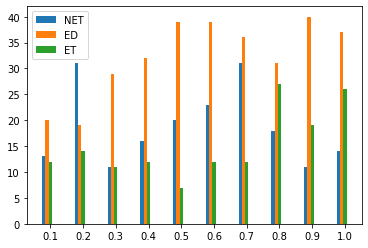

In [33]:
plt.figure()
lab_code = {
    0: "WT", 1: "NET", 2: "ED", 3: "ET"
}
width = 0.1

x = np.arange(len(bins_upper_limit))
for lab in [1, 2, 3]:
    len_dict = {
        b: len(l) for b, l in dice_dict_bins[lab].items()
    }
    plt.bar(x, list(len_dict.values()), width=width, label=lab_code[lab])
    x = [i + width for i in x]

final_tick_pos = np.arange(len(bins_upper_limit)) + 2*width
plt.xticks(final_tick_pos, list(map(str, bins_upper_limit)))
plt.legend()
plt.show()


In [38]:
from torchvision.transforms import RandomAffine
affine_transformer = RandomAffine(degrees=(30, 60), scale=(0.7, 0.8))
a = torch.ones((1, 1, 50, 50))
b = affine_transformer(a)
b.size()

torch.Size([1, 1, 50, 50])